In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import text
from sqlalchemy import select, or_
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
engine = sqlalchemy.create_engine("sqlite:///monitoring.db")
conn = engine.connect()
trys = pd.read_sql(f"SELECT task_id, block_id, task_try_time_launched FROM try ORDER BY task_try_time_launched", conn)
trys["func_name"] = "sleep"
trys.loc[:100, "func_name"] = "compute_iters"
trys.loc[200:, "func_name"] = "gemm"

energy = pd.read_sql(f"SELECT * FROM energy", conn)
energy["timestamp"] = pd.to_datetime(energy['timestamp'])
energy["power"] = energy["total_energy"] / energy["duration"]
energy = energy.sort_values("timestamp", ignore_index=True)

status = pd.read_sql(f"SELECT * FROM status WHERE (task_status_name='running_ended' OR task_status_name='running')", conn)
status["timestamp"] = pd.to_datetime(status['timestamp'])
status = pd.merge(status, trys[["task_id", "func_name"]], on="task_id", how="left")
status = status.sort_values("timestamp", ignore_index=True)
status["value"] = 1
status.loc[status["task_status_name"] == "running_ended", "value"] = -1
status["running"] = status["value"].cumsum()
status["running_per_task"] = status.groupby("func_name")["value"].cumsum()

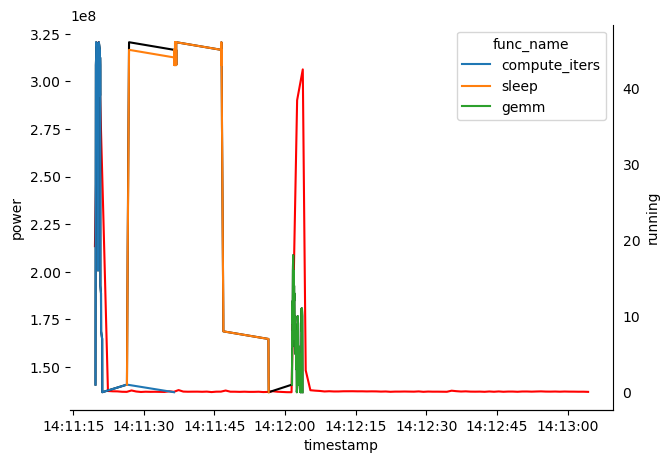

In [3]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(energy[1:], x="timestamp", y="power", ax=ax, color="red")
ax2 = ax.twinx()
sns.lineplot(status, x="timestamp", y="running", ax=ax2, color="black")
sns.lineplot(status, x="timestamp", y="running_per_task", ax=ax2, hue="func_name")
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)

In [4]:
resources = pd.read_sql(f"SELECT * FROM resource WHERE psutil_process_name='process_worker_'", conn)
resources["timestamp"] = pd.to_datetime(resources['timestamp'])
resources = resources.sort_values("timestamp", ignore_index=True)
resources = resources.loc[:,~resources.columns.str.startswith('psutil_process_')]
resources = resources.drop(["run_id"], axis=1)
resources

,pid,timestamp,perf_unhalted_core_cycles,perf_unhalted_reference_cycles,perf_llc_misses,perf_instructions_retired
0,2764848,2023-08-16 14:11:19.445742,100471,101160,45,88664
1,2764848,2023-08-16 14:11:19.523420,4195384,4210080,1277,2573006
2,2764949,2023-08-16 14:11:19.524678,454,480,0,1
3,2764954,2023-08-16 14:11:19.525653,281416,281880,1253,178330
4,2764957,2023-08-16 14:11:19.527749,1198544,1215120,3277,1323512
...,...,...,...,...,...,...
5074,2765083,2023-08-16 14:13:04.367313,1488839199,1489633320,2538344,5043447079
5075,2765086,2023-08-16 14:13:04.367660,1306704419,1306987920,1718969,4545136857
5076,2765089,2023-08-16 14:13:04.367995,1316454260,1316974080,1730048,4542634225
5077,2765092,2023-08-16 14:13:04.368330,1353609762,1353998400,1675414,4719347111


In [5]:
def split(df):
    gb = df.groupby(['pid'])
    return [gb.get_group(x) for x in gb.groups]

df_split = split(resources)

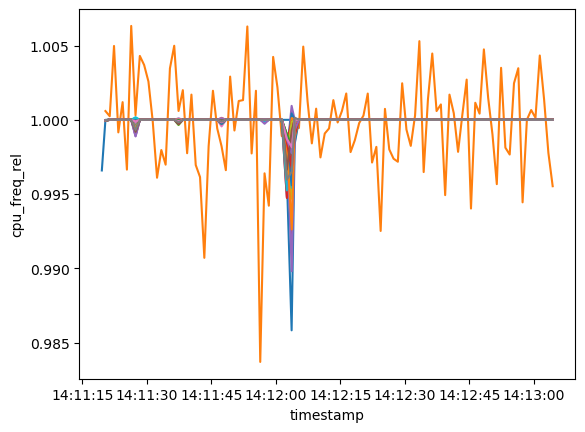

In [6]:
df_split_clean = []
for i in range(len(df_split)):
    df_new = df_split[i].diff()
    df_new["timestamp"] = (df_new["timestamp"] / np.timedelta64(1, "s"))
    df_new = df_new.div(df_new["timestamp"], axis='index')
    df_new["cpu_freq_rel"] = (df_new["perf_unhalted_core_cycles"] + .000001) / (df_new["perf_unhalted_reference_cycles"] + .000001) 
    df_new["pid"] = df_split[i]["pid"]
    df_new["timestamp"] = df_split[i]["timestamp"]
    df_new = df_new.set_index("timestamp")
    df_split_clean.append(df_new)
    sns.lineplot(df_split_clean[i], x="timestamp", y="cpu_freq_rel")

In [7]:
def sum_resources(df1, df2, columns=["perf_unhalted_core_cycles", "perf_unhalted_reference_cycles", "perf_llc_misses", "perf_instructions_retired", "cpu_freq_rel"]):
    df = pd.merge_asof(df1[columns], df2[columns], on="timestamp", direction="forward")
    for col in columns:
        df[col] = df[f"{col}_x"] + df[f"{col}_y"]
        df = df.drop([f"{col}_x", f"{col}_y"], axis=1)
    df = df.set_index("timestamp")
    return df

In [8]:
df = df_split_clean[0]
for i in range(1, len(df_split_clean)):
    df = sum_resources(df, df_split_clean[i])
df

,perf_unhalted_core_cycles,perf_unhalted_reference_cycles,perf_llc_misses,perf_instructions_retired,cpu_freq_rel
timestamp,,,,,
2023-08-16 14:11:19.445742,NaN,NaN,NaN,NaN,NaN
2023-08-16 14:11:19.523420,NaN,NaN,NaN,NaN,NaN
2023-08-16 14:11:20.358959,NaN,NaN,NaN,NaN,NaN
2023-08-16 14:11:21.358022,6.167224e+10,6.167212e+10,623540.829442,2.297204e+11,48.000373
2023-08-16 14:11:22.354481,1.500744e+04,1.493318e+04,10.035737,1.657603e+04,48.004973
...,...,...,...,...,...
2023-08-16 14:13:00.352650,1.452505e+04,1.452305e+04,5.001050,1.652047e+04,48.000138
2023-08-16 14:13:01.351994,1.531602e+04,1.524997e+04,3.001963,1.652781e+04,48.004331
2023-08-16 14:13:02.353040,2.100707e+04,2.097810e+04,2.996871,1.649977e+04,48.001381


In [9]:
df_combined = pd.merge_asof(energy, df, on="timestamp", direction="backward")
df_combined

,run_id,block_id,hostname,timestamp,duration,total_energy,resource_monitoring_interval,devices,power,perf_unhalted_core_cycles,perf_unhalted_reference_cycles,perf_llc_misses,perf_instructions_retired,cpu_freq_rel
0,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:11:19.448261,0.751630,139968148.0,1.0,"{""package-0"": {""start_time"": 14594676.21849440...",1.862194e+08,NaN,NaN,NaN,NaN,NaN
1,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:11:19.607918,0.159898,34132541.0,1.0,"{""package-0"": {""start_time"": 14594676.97012474...",2.134648e+08,NaN,NaN,NaN,NaN,NaN
2,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:11:20.382190,0.774211,248121130.0,1.0,"{""package-0"": {""start_time"": 14594677.13002252...",3.204828e+08,NaN,NaN,NaN,NaN,NaN
3,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:11:21.377229,0.995156,229746422.0,1.0,"{""package-0"": {""start_time"": 14594677.90423304...",2.308647e+08,6.167224e+10,6.167212e+10,623540.829442,2.297204e+11,48.000373
4,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:11:22.372067,0.994878,136746415.0,1.0,"{""package-0"": {""start_time"": 14594678.89938909...",1.374504e+08,1.500744e+04,1.493318e+04,10.035737,1.657603e+04,48.004973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:13:00.370733,0.999685,137074600.0,1.0,"{""package-0"": {""start_time"": 14594776.89326373...",1.371177e+08,1.452505e+04,1.452305e+04,5.001050,1.652047e+04,48.000138
103,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:13:01.370115,0.999350,137018448.0,1.0,"{""package-0"": {""start_time"": 14594777.89294921...",1.371076e+08,1.531602e+04,1.524997e+04,3.001963,1.652781e+04,48.004331
104,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:13:02.371127,1.001051,137210891.0,1.0,"{""package-0"": {""start_time"": 14594778.89229901...",1.370669e+08,2.100707e+04,2.097810e+04,2.996871,1.649977e+04,48.001381
105,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:13:03.370605,0.999468,137004593.0,1.0,"{""package-0"": {""start_time"": 14594779.89334974...",1.370775e+08,1.796974e+04,1.800976e+04,3.001627,1.652596e+04,47.997778


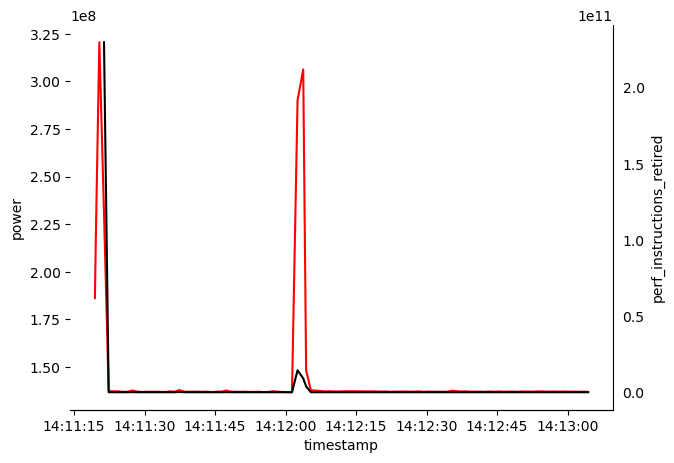

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(df_combined, x="timestamp", y="power", ax=ax, color="red")
ax2 = ax.twinx()
sns.lineplot(df_combined, x="timestamp", y="perf_instructions_retired", ax=ax2, color="black")
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)

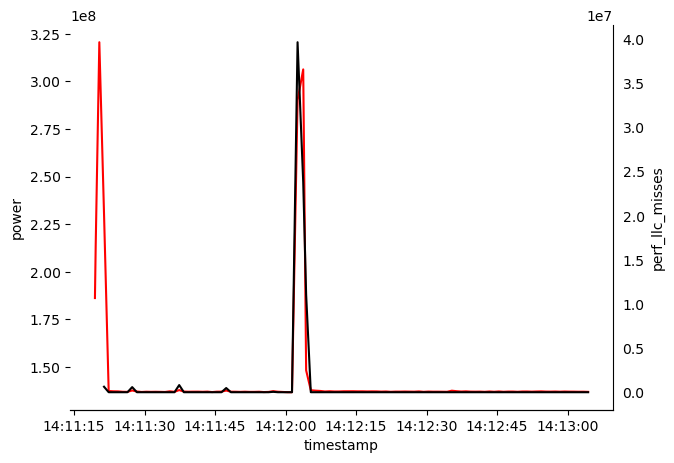

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(df_combined, x="timestamp", y="power", ax=ax, color="red")
ax2 = ax.twinx()
sns.lineplot(df_combined, x="timestamp", y="perf_llc_misses", ax=ax2, color="black")
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)

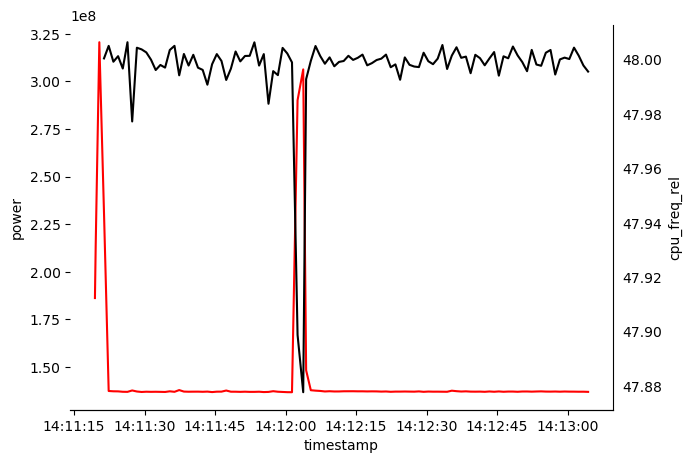

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(df_combined, x="timestamp", y="power", ax=ax, color="red")
ax2 = ax.twinx()
sns.lineplot(df_combined, x="timestamp", y="cpu_freq_rel", ax=ax2, color="black")
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)

In [14]:
from sklearn.linear_model import ElasticNet

/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.898e+15, tolerance: 5.911e+12
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_13875/1865131211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined["pred_power"] = regr.predict(df_combined[["perf_instructions_retired", "perf_llc_misses"]])


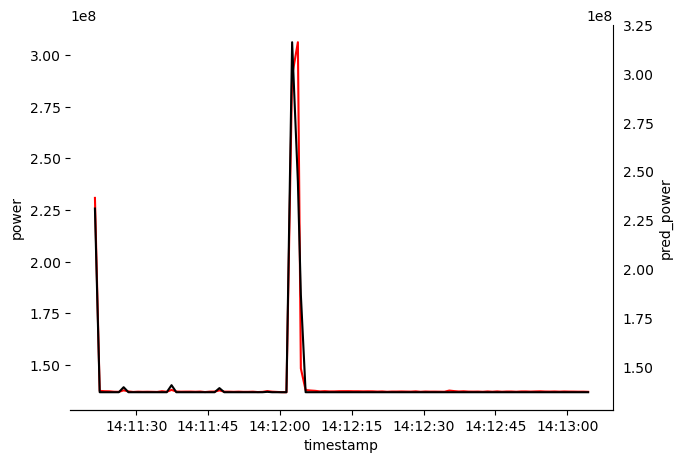

In [16]:
df_combined = df_combined.dropna()
regr = ElasticNet(random_state=0)
regr.fit(df_combined[["perf_instructions_retired", "perf_llc_misses"]], df_combined["power"])
df_combined["pred_power"] = regr.predict(df_combined[["perf_instructions_retired", "perf_llc_misses"]])

fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(df_combined, x="timestamp", y="power", ax=ax, color="red")
ax2 = ax.twinx()
sns.lineplot(df_combined, x="timestamp", y="pred_power", ax=ax2, color="black")
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)